<a href="https://colab.research.google.com/github/qkrdudwls/DM/blob/main/DM_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Mining Project**

## Set up

### 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Selenium 설치 & 구글 드라이브에 chromedriver 설치

In [ ]:
!pip install selenium
!apt-get update

!apt install chromium-chromedriver
!cp /usr/bin/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 36.6 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204

### Spark 설치

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 55 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 124094 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

### Word Cloud & NLTK & spaCy 설치
- NLTK의 stopwords, punkt 패키지 다운로드

In [ ]:
!pip install wordcloud
!pip install nltk
!pip install spacy

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Version 확인

In [ ]:
!python --version

import selenium
import pyspark
import wordcloud
import nltk
import spacy

print(f"Selenium {selenium.__version__}")
print(f"PySpark {pyspark.__version__}")
print(f"Word Cloud {wordcloud.__version__}")
print(f"NLTK {nltk.__version__}")
print(f"spaCy {spacy.__version__}")

Python 3.10.12
Selenium 4.26.1
PySpark 3.5.3
Word Cloud 1.9.4
NLTK 3.9.1
spaCy 3.7.5


### Import Library

In [ ]:
# Crawling
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller
import re

# WordCloud
import glob
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover, CountVectorizer
from pyspark.sql.functions import col, explode, udf, lower, regexp_replace
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DoubleType
from pyspark.ml.linalg import SparseVector
from wordcloud import WordCloud
import spacy
import nltk
from nltk.corpus import stopwords

### chrome_options 설정

In [ ]:
chrome_path="/content/drive/Mydrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

chromedriver_autoinstaller.install()

## Crawling

### URL 설정

In [ ]:
bible_url = 'https://www.gutenberg.org/cache/epub/10/pg10-images.html'
quran_url = 'https://www.gutenberg.org/cache/epub/2800/pg2800-images.html'

### 데이터 전처리 함수
- 영어 알파벳과 공백만 제외하고 모두 제거
- 모든 문자를 소문자로 변환
- 연속된 공백을 단일 공백으로 축소
- 양 끝의 공백 제거

In [ ]:
def preprocess_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text.strip()

### Bible

In [ ]:
# 드라이버 설정
bible_chapter_driver = webdriver.Chrome(options=chrome_options)
bible_chapter_driver.get(bible_url)
wait = WebDriverWait(bible_chapter_driver, 10)

# bible_texts 폴더가 없으면 생성
output_folder = "bible_texts"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

try:
    # 모든 'chapter' 클래스 div 요소 찾기
    chapter_divs = bible_chapter_driver.find_elements(By.CLASS_NAME, "chapter")

    # 첫 번째 div는 건너뛰고 두 번째 div부터 순회 (첫 번째 div는 제목)
    for index, chapter_div in enumerate(chapter_divs[1:], start=2):
        # 텍스트 추출 및 전처리 (영어만 남기기)
        chapter_text = chapter_div.get_attribute("textContent")
        chapter_text = preprocess_text(chapter_text)  # 전처리 함수 적용
        chapter_text = chapter_text.strip()  # 앞뒤 공백 제거

        # 파일로 저장
        if chapter_text:  # 내용이 있을 경우에만 저장
            filename = os.path.join(output_folder, f"chapter_{index-1}.txt")
            with open(filename, "w", encoding="utf-8") as file:
                file.write(chapter_text)
            print(f"Saved text from div #{index-1} to {filename}")

except Exception as e:
    print("Error:", e)

finally:
    # 드라이버 종료
    bible_chapter_driver.quit()

Saved text from div #1 to bible_texts/chapter_1.txt
Saved text from div #2 to bible_texts/chapter_2.txt
Saved text from div #3 to bible_texts/chapter_3.txt
Saved text from div #4 to bible_texts/chapter_4.txt
Saved text from div #5 to bible_texts/chapter_5.txt
Saved text from div #6 to bible_texts/chapter_6.txt
Saved text from div #7 to bible_texts/chapter_7.txt
Saved text from div #8 to bible_texts/chapter_8.txt
Saved text from div #9 to bible_texts/chapter_9.txt
Saved text from div #10 to bible_texts/chapter_10.txt
Saved text from div #11 to bible_texts/chapter_11.txt
Saved text from div #12 to bible_texts/chapter_12.txt
Saved text from div #13 to bible_texts/chapter_13.txt
Saved text from div #14 to bible_texts/chapter_14.txt
Saved text from div #15 to bible_texts/chapter_15.txt
Saved text from div #16 to bible_texts/chapter_16.txt
Saved text from div #17 to bible_texts/chapter_17.txt
Saved text from div #18 to bible_texts/chapter_18.txt
Saved text from div #19 to bible_texts/chapter

### Quran

In [ ]:
# 드라이버 설정
quran_chapter_driver = webdriver.Chrome(options=chrome_options)
quran_chapter_driver.get(quran_url)
wait = WebDriverWait(quran_chapter_driver, 10)

# 저장할 폴더 생성
output_dir = 'quran_texts'
os.makedirs(output_dir, exist_ok=True)

current_document = []  # 현재 문서의 텍스트를 저장할 리스트
chapter_count = 1  # 챕터 카운터
start_crawling = False  # 첫 번째 <h4> 이후 크롤링 시작

try:
    # 페이지의 모든 태그를 순서대로 가져옴
    elements = quran_chapter_driver.find_elements(By.XPATH, "//*[name()='h4' or name()='p' or @id='pg-end-separator']")

    for element in elements:
        # 크롤링 종료 조건: <div id="pg-end-separator"> 발견 시
        if element.tag_name == 'div' and element.get_attribute('id') == 'pg-end-separator':
            break

        # 첫 번째 <h4> 이후 크롤링 시작
        if element.tag_name == 'h4':
            start_crawling = True  # 첫 번째 <h4> 발견 시 True로 설정

            if current_document:  # 현재 문서가 비어있지 않다면 데이터를 파일로 저장
                # 전처리 및 병합
                quran_processed_text = ' '.join(preprocess_text(' '.join(current_document)).split())

                # 파일 저장
                with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
                    file.write(quran_processed_text)

                print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")  # 진행 상황 출력

                chapter_count += 1  # 챕터 카운트 증가
                current_document = []  # 새로운 문서 시작을 위해 초기화

        # <p> 태그의 텍스트 수집
        if start_crawling and element.tag_name == 'p':
            quran_text = preprocess_text(element.text.strip())
            current_document.append(quran_text)

    # 마지막 문서 저장
    if current_document:
        quran_processed_text = ' '.join(preprocess_text(' '.join(current_document)).split())
        with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
            file.write(quran_processed_text)
        print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")  # 마지막 챕터 저장 출력

except Exception as e:
    print("Error:", e)

# 드라이버 종료
quran_chapter_driver.quit()

Saved chapter 1 to quran_texts/chapter_1.txt
Saved chapter 2 to quran_texts/chapter_2.txt
Saved chapter 3 to quran_texts/chapter_3.txt
Saved chapter 4 to quran_texts/chapter_4.txt
Saved chapter 5 to quran_texts/chapter_5.txt
Saved chapter 6 to quran_texts/chapter_6.txt
Saved chapter 7 to quran_texts/chapter_7.txt
Saved chapter 8 to quran_texts/chapter_8.txt
Saved chapter 9 to quran_texts/chapter_9.txt
Saved chapter 10 to quran_texts/chapter_10.txt
Saved chapter 11 to quran_texts/chapter_11.txt
Saved chapter 12 to quran_texts/chapter_12.txt
Saved chapter 13 to quran_texts/chapter_13.txt
Saved chapter 14 to quran_texts/chapter_14.txt
Saved chapter 15 to quran_texts/chapter_15.txt
Saved chapter 16 to quran_texts/chapter_16.txt
Saved chapter 17 to quran_texts/chapter_17.txt
Saved chapter 18 to quran_texts/chapter_18.txt
Saved chapter 19 to quran_texts/chapter_19.txt
Saved chapter 20 to quran_texts/chapter_20.txt
Saved chapter 21 to quran_texts/chapter_21.txt
Saved chapter 22 to quran_texts

## TF-IDF 계산 및 시각화
- TF-IDF 점수가 가장 높은 상위 100개의 단어로 Word Cloud 생성
- 데이터 전처리: 대명사와 전치사 등 상대적으로 덜 중요한 단어 제거
  - NLTK, spaCy, 사용자 정의 불용어 목록 사용

### Bible

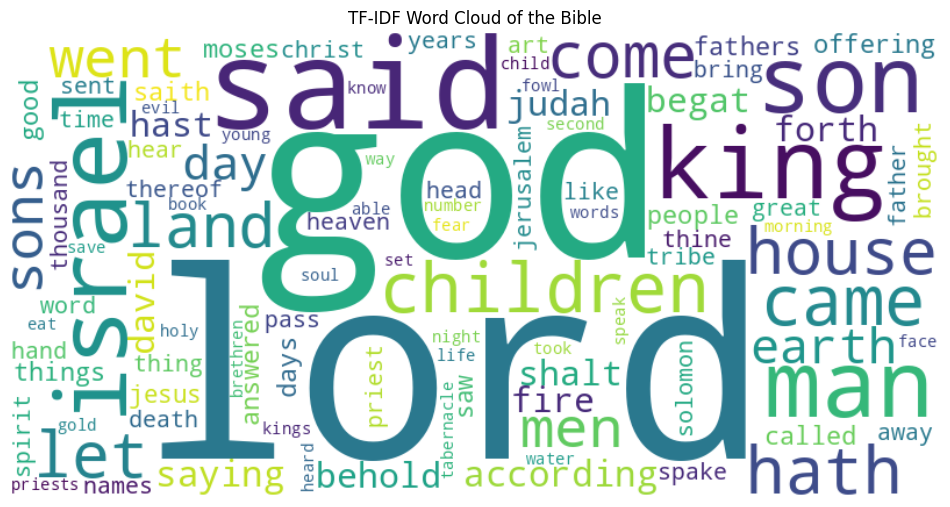

In [ ]:
# nltk의 영어 불용어 목록 설정
nltk_stopwords = set(nltk.corpus.stopwords.words('english'))

# spaCy의 불용어 목록 사용
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words

# 사용자 정의 불용어 추가 및 결합
custom_stopwords = ["unto", "shall", "thy", "thee", "thou", "ye"]  # 필요에 따라 추가
all_stopwords = list(nltk_stopwords | spacy_stopwords | set(custom_stopwords))

# Spark 세션 생성
spark = SparkSession.builder.appName("TF-IDF of the Bible").config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").getOrCreate()

# 문서 로드
file_paths = sorted(glob.glob("bible_texts/chapter_*.txt"))
documents = [(i, open(file, 'r', encoding='utf-8').read()) for i, file in enumerate(file_paths)]
df = spark.createDataFrame(documents, ["doc_id", "text"])

# 텍스트 전처리: 소문자로 변환 및 특수 문자 제거
df = df.withColumn("text", regexp_replace(lower(col("text")), "[^a-zA-Z\\s]", ""))

# 텍스트 토큰화
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_data = tokenizer.transform(df).cache()  # cache() 사용

# 불용어 제거
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)
filtered_words_data = remover.transform(words_data).cache()

# TF (Term Frequency) 생성
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=500)
featurized_data = hashingTF.transform(filtered_words_data).cache()

# IDF 생성 및 TF-IDF 계산
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data).cache()

# TF-IDF 벡터에서 각 단어와 그 TF-IDF 값을 추출하는 UDF 정의
def extract_words_and_tfidf(features, words):
    if isinstance(features, SparseVector):
        return [(words[idx], float(features.values[i])) for i, idx in enumerate(features.indices) if idx < len(words)]
    return []

extract_udf = udf(extract_words_and_tfidf, ArrayType(StructType([StructField("word", StringType()),StructField("tfidf", DoubleType())])))

# 단어와 TF-IDF 점수 추출
exploded_data = rescaled_data.withColumn("word_tfidf", explode(extract_udf(col("features"), col("filtered_words"))))
word_tfidf_df = exploded_data.select(col("word_tfidf.word").alias("word"), col("word_tfidf.tfidf").alias("tfidf_score"))

# 상위 100개 단어 추출 및 Pandas로 변환
top_words = word_tfidf_df.groupBy("word").sum("tfidf_score").withColumnRenamed("sum(tfidf_score)", "tfidf_score")
word_tfidf_pd_bible = top_words.orderBy(col("tfidf_score"), ascending=False).limit(100).toPandas()

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(word_tfidf_pd_bible.word, word_tfidf_pd_bible.tfidf_score))
)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of the Bible")
plt.show()

### Quran

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


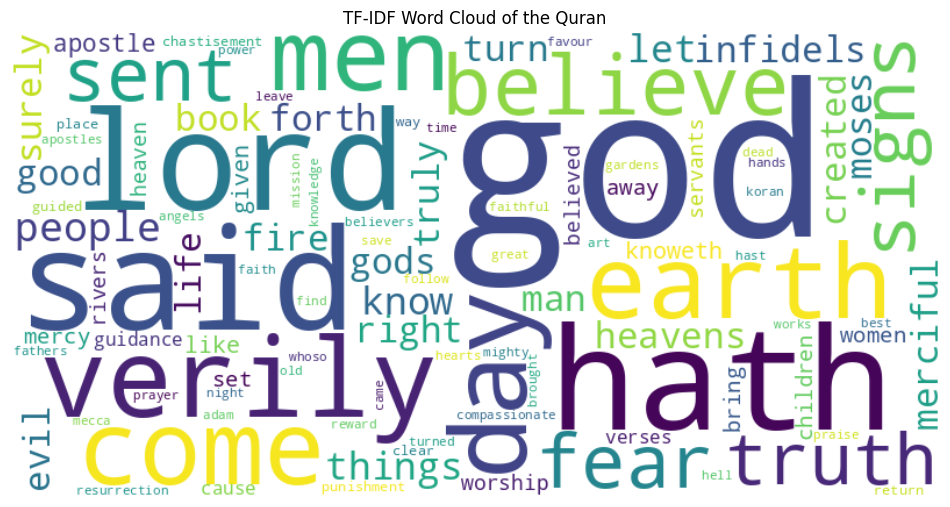

In [ ]:
# nltk의 영어 불용어 목록 설정
nltk_stopwords = set(nltk.corpus.stopwords.words('english'))

# spaCy의 불용어 목록 사용
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words

# 사용자 정의 불용어 추가 및 결합
custom_stopwords = ["unto", "shall", "thy", "thee", "ye", "thou"]  # 필요에 따라 추가
all_stopwords = list(nltk_stopwords | spacy_stopwords | set(custom_stopwords))

# Spark 세션 생성
spark = SparkSession.builder.appName("TF-IDF of the Quran").config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").getOrCreate()

# 문서 로드
file_paths = sorted(glob.glob("quran_texts/chapter_*.txt"))
documents = [(i, open(file, 'r', encoding='utf-8').read()) for i, file in enumerate(file_paths)]
df = spark.createDataFrame(documents, ["doc_id", "text"])

# 텍스트 전처리: 소문자로 변환 및 특수 문자 제거
df = df.withColumn("text", regexp_replace(lower(col("text")), "[^a-zA-Z\\s]", ""))

# 텍스트 토큰화
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_data = tokenizer.transform(df).cache()  # cache() 사용

# 불용어 제거
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)
filtered_words_data = remover.transform(words_data).cache()

# TF (Term Frequency) 생성
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=500)
featurized_data = hashingTF.transform(filtered_words_data).cache()

# IDF 생성 및 TF-IDF 계산
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data).cache()

# TF-IDF 벡터에서 각 단어와 그 TF-IDF 값을 추출하는 UDF 정의
def extract_words_and_tfidf(features, words):
    if isinstance(features, SparseVector):
        indices = features.indices
        values = features.values
        # Check if indices and values are of the same length
        if len(indices) != len(values):
            return []  # Return empty if there's a mismatch
        return [(words[i], float(values[idx])) for idx, i in enumerate(indices) if i < len(words)]
    else:
        return []

extract_udf = udf(extract_words_and_tfidf, ArrayType(StructType([StructField("word", StringType()),StructField("tfidf", DoubleType())])))

# 단어와 TF-IDF 점수 추출
exploded_data = rescaled_data.withColumn("word_tfidf", explode(extract_udf(col("features"), col("filtered_words"))))
word_tfidf_df = exploded_data.select(col("word_tfidf.word").alias("word"), col("word_tfidf.tfidf").alias("tfidf_score"))

# 상위 100개 단어 추출 및 Pandas로 변환
top_words = word_tfidf_df.groupBy("word").sum("tfidf_score").withColumnRenamed("sum(tfidf_score)", "tfidf_score")
word_tfidf_pd_quran = top_words.orderBy(col("tfidf_score"), ascending=False).limit(100).toPandas()

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(word_tfidf_pd_quran.word, word_tfidf_pd_quran.tfidf_score))
)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of the Quran")
plt.show()

# Spark 세션 종료
spark.stop()

### Commonness
- Bible과 Quran의 TF-IDF 결과에서 각각 상위 N개 단어 추출
- 추출한 N개의 단어 중 공통으로 존재하는 단어로 워드 클라우드 생성

#### N값 설정

- N: 10 ~ 150

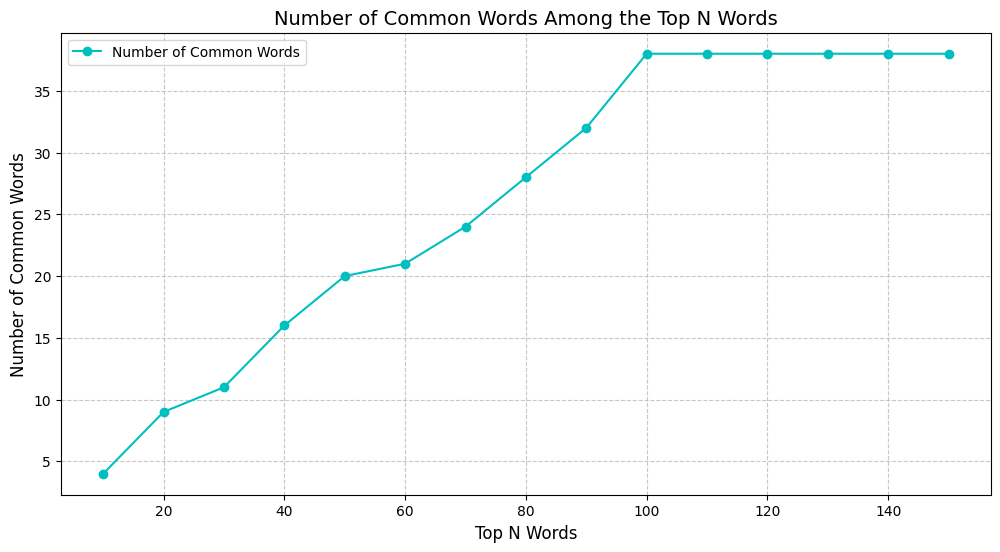

In [ ]:
# N 값 범위 설정
N_values = list(range(10, 160, 10))
common_word_counts = []

# 반복적으로 N값 변화에 따라 공통 단어 개수 계산
for N in N_values:
    # 상위 N개의 단어 추출 (단어 열 이름이 "word"라고 가정)
    top_N_bible = word_tfidf_pd_bible.sort_values(by="tfidf_score", ascending=False).head(N)
    top_N_quran = word_tfidf_pd_quran.sort_values(by="tfidf_score", ascending=False).head(N)

    # 단어 열 이름이 정확한지 확인
    if "word" not in top_N_bible.columns or "word" not in top_N_quran.columns:
        print("Error: 단어 열 이름이 'word'가 아닙니다.")
        break

    # 단어를 소문자로 변환하여 정규화 (대소문자 구분 방지)
    bible_words_set = set(top_N_bible["word"].str.lower().str.strip())
    quran_words_set = set(top_N_quran["word"].str.lower().str.strip())

    # 공통 단어 추출
    common_words = bible_words_set.intersection(quran_words_set)

    # 공통 단어 개수 저장
    common_word_counts.append(len(common_words))

# 꺾은선 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(N_values, common_word_counts, marker='o', linestyle='-', color='c', label="Number of Common Words")
plt.title("Number of Common Words Among the Top N Words", fontsize=14)
plt.xlabel("Top N Words", fontsize=12)
plt.ylabel("Number of Common Words", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

- N: 100 ~ 5000

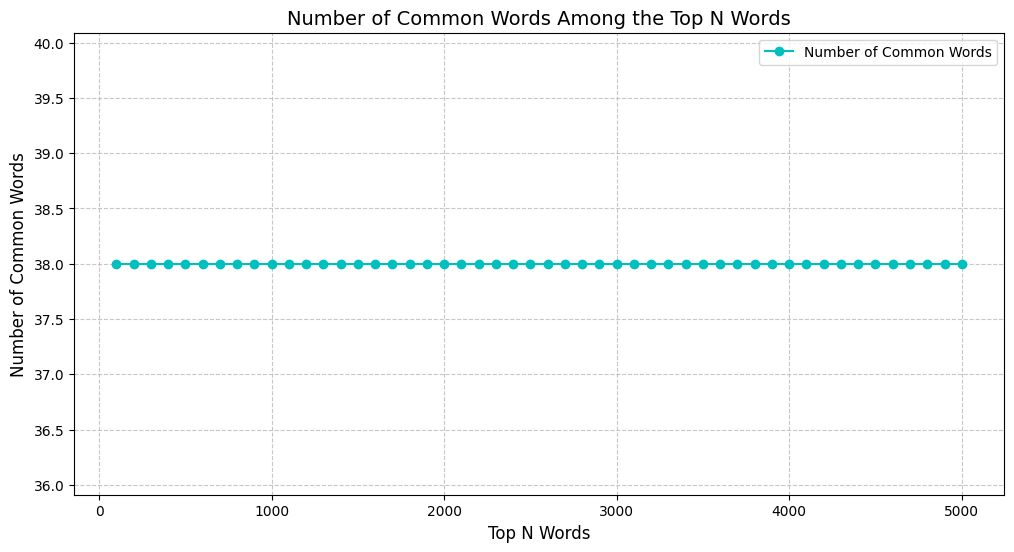

In [ ]:
# N 값 범위 설정
N_values = list(range(100, 5100, 100))
common_word_counts = []

# 반복적으로 N값 변화에 따라 공통 단어 개수 계산
for N in N_values:
    # 상위 N개의 단어 추출 (단어 열 이름이 "word"라고 가정)
    top_N_bible = word_tfidf_pd_bible.sort_values(by="tfidf_score", ascending=False).head(N)
    top_N_quran = word_tfidf_pd_quran.sort_values(by="tfidf_score", ascending=False).head(N)

    # 단어 열 이름이 정확한지 확인
    if "word" not in top_N_bible.columns or "word" not in top_N_quran.columns:
        print("Error: 단어 열 이름이 'word'가 아닙니다.")
        break

    # 단어를 소문자로 변환하여 정규화 (대소문자 구분 방지)
    bible_words_set = set(top_N_bible["word"].str.lower().str.strip())
    quran_words_set = set(top_N_quran["word"].str.lower().str.strip())

    # 공통 단어 추출
    common_words = bible_words_set.intersection(quran_words_set)

    # 공통 단어 개수 저장
    common_word_counts.append(len(common_words))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(N_values, common_word_counts, marker='o', linestyle='-', color='c', label="Number of Common Words")
plt.title("Number of Common Words Among the Top N Words", fontsize=14)
plt.xlabel("Top N Words", fontsize=12)
plt.ylabel("Number of Common Words", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

#### Word Cloud 생성

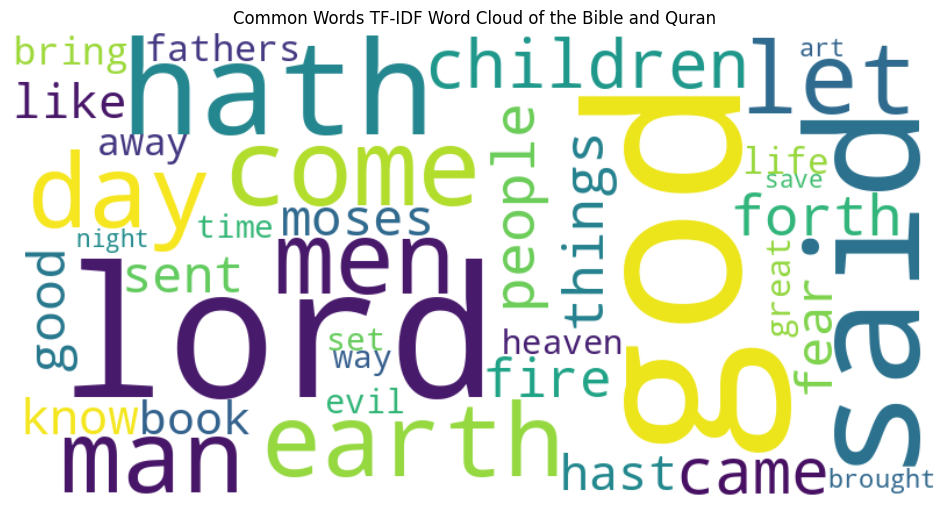

In [ ]:
# 상위 100개 단어 추출 (Bible과 Quran의 TF-IDF 결과에서 각각)
N=100
top_N_bible = word_tfidf_pd_bible.sort_values(by="tfidf_score", ascending=False).head(N)  # Bible의 TF-IDF 결과
top_N_quran = word_tfidf_pd_quran.sort_values(by="tfidf_score", ascending=False).head(N)  # Quran의 TF-IDF 결과

# 공통 단어 추출
bible_words_set = set(top_N_bible["word"])
quran_words_set = set(top_N_quran["word"])
common_words = bible_words_set.intersection(quran_words_set)

# Bible과 Quran에서 공통 단어에 대해 TF-IDF 점수 합산
bible_common_tfidf = top_N_bible[top_N_bible["word"].isin(common_words)].set_index("word")["tfidf_score"]
quran_common_tfidf = top_N_quran[top_N_quran["word"].isin(common_words)].set_index("word")["tfidf_score"]

# 공통 단어에 대한 TF-IDF 점수 합산
combined_tfidf = (bible_common_tfidf + quran_common_tfidf).fillna(0)

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(combined_tfidf.to_dict())

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words TF-IDF Word Cloud of the Bible and Quran")
plt.show()